In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
from matplotlib import cm
from math import isinf
from scipy.optimize import linprog
import random

In [2]:
class NonStationaryPricingEnvironment:
    def __init__(self, cost, prices):
        self.cost = cost
        self.prices = prices
        self.distributions = [stats.uniform(0,1), stats.norm(0.7,0.2)]

    def round(self, p_t, n_t, price):
        d_t = np.random.binomial(n_t, self.win_probabilities[p_t])
        r_t = (price - self.cost)*d_t
        return d_t, r_t
    def set(self):
        self.valuation = random.choice(self.distributions)
        self.win_probabilities = 1 - self.valuation.cdf(self.prices)

In [19]:
class UCBLikeAgent():
    def __init__(self, K, B, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None # it's an index, not the actual bid
        self.avg_f = np.zeros(K)
        self.avg_c = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.budget = B
        self.rho = B/T
        self.t = 0
    
    def pull_arm(self):
        if self.budget < 1:
            return -1
        if self.t < self.K:
            self.a_t = self.t 
        else:
            f_ucbs = self.avg_f + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            c_lcbs = self.avg_c - self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            gamma_t = self.compute_opt(f_ucbs, c_lcbs)
            self.a_t = np.random.choice(self.K, p=gamma_t)
        return self.a_t

    def compute_opt(self, f_ucbs, c_lcbs):
        if np.sum(c_lcbs <= np.zeros(len(c_lcbs))):
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1
            return gamma
        c = -f_ucbs
        A_ub = [c_lcbs]
        b_ub = [self.rho]
        A_eq = [np.ones(self.K)]
        b_eq = [1]
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
        gamma = res.x
        return gamma
    
    def update(self, f_t, c_t):
        self.N_pulls[self.a_t] += 1
        self.avg_f[self.a_t] += (f_t - self.avg_f[self.a_t])/self.N_pulls[self.a_t]
        self.avg_c[self.a_t] += (c_t - self.avg_c[self.a_t])/self.N_pulls[self.a_t]
        self.budget -= c_t
        self.t += 1

In [20]:
## Linear Program
def compute_clairvoyant(prices, rho, win_probabilities):
    c = -prices
    A_ub = [prices*win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(prices))]
    b_eq = [1]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    gamma = res.x
    
    return gamma, -res.fun

In [21]:
n_t = 1
T = 1000
B = 300
rho = B/T
epsilon = T**(-0.33)
K = int(1/epsilon)
prices = np.linspace(0,1,K)
n_epochs = 100
all_regrets = []
all_payments = []
all_pulls = []
for i in range(n_epochs):

    agent = UCBLikeAgent(K, B,T, range=1)
    env = NonStationaryPricingEnvironment(0, prices)
    
    utilities = []
    my_prices = []
    my_payments = []
    total_wins = 0
    clairv_util = []

    np.random.seed(i)
    for u in range(T):
        env.set()
        gamma, exp_clairv_util = compute_clairvoyant(prices, rho, env.win_probabilities)
        # interaction
        index = agent.pull_arm()
        if index != -1:
            my_price = prices[index]
            c_t, f_t = env.round(index, n_t, my_price)
            agent.update(f_t, c_t)
        else:
            f_t = 0
            my_price = prices[K-1]
            c_t = 0    
        # logging
        utilities.append(f_t)
        clairv_util.append(exp_clairv_util)
        my_prices.append(my_price)
        my_payments.append(c_t)
        total_wins+=c_t

    utilities = np.array(utilities)
    my_prices = np.array(my_prices)
    my_payments = np.array(my_payments)
    expected_clairvoyant_utility = np.array(clairv_util)
    print(f'Total # of Wins: {total_wins}')
    all_regrets.append(np.cumsum(expected_clairvoyant_utility-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_pulls.append(agent.N_pulls)

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_pulls = np.array(all_pulls).mean(axis=0)
std_pulls = np.array(all_pulls).std(axis=0)


Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wins: 300
Total # of Wi

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\digio\AppData\Local\Temp\ipykernel_44624\3233678207.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')
C:\Users\digio\AppData\Local\Temp\ipykernel_44624\3233678207.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum R_t$')


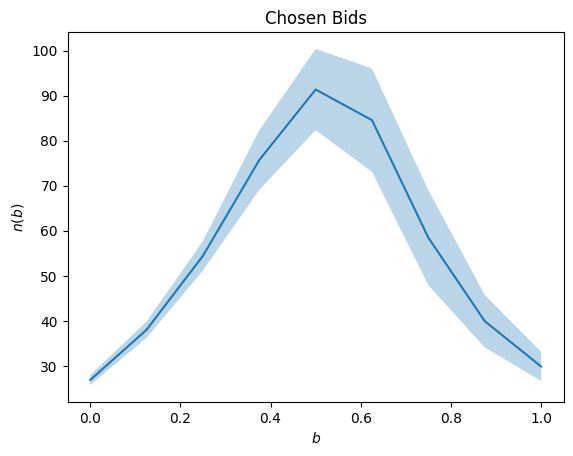

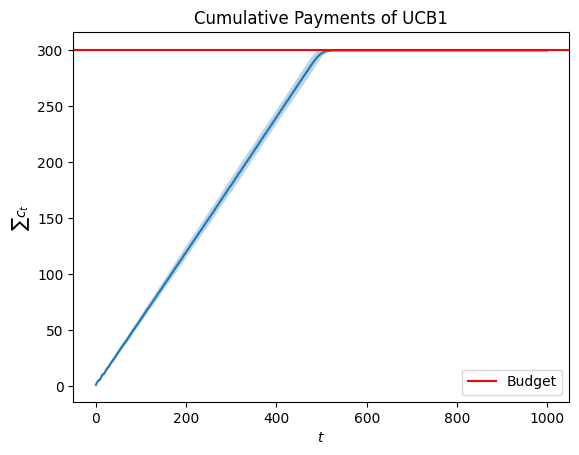

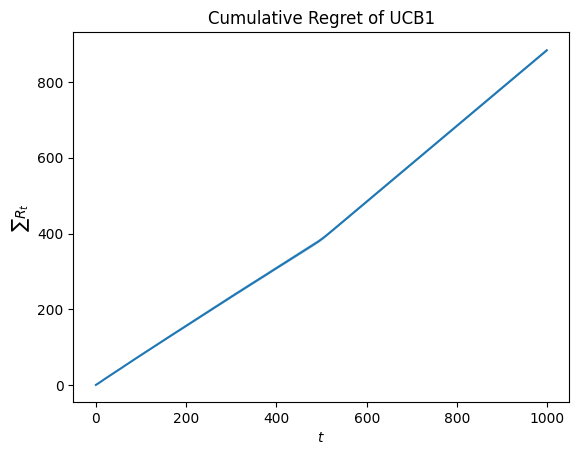

In [22]:
plt.plot(prices, avg_pulls)
plt.fill_between(prices, avg_pulls-std_pulls, avg_pulls+std_pulls, alpha=0.3)
plt.plot()
plt.xlabel('$b$')
plt.ylabel('$n(b)$')
plt.title('Chosen Bids')
plt.show()

plt.plot(np.arange(T), avg_payments)
plt.fill_between(np.arange(T), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of UCB1')
plt.show()

plt.plot(np.arange(T), avg_regret)
plt.fill_between(np.arange(T), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of UCB1')
plt.show()